In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from functions import *

In [2]:
fname = 'data/3D/wing_init/output/wing_000_slices.dat'
data_3d = read_3d_slice_data(fname)
data_3d.pop()

for df in data_3d:
    df['CoordinateX'] = df['CoordinateX'] - df['CoordinateX'].values[0]
    df['CoordinateY'] = df['CoordinateY'] - df['CoordinateY'].values[0]

In [3]:
fname = 'data/2D/case_372/fc_000_slices.dat'
df_2d = read_2d_slice_data(fname)
# Shift leading edge to (0,0)
df_2d['CoordinateX'] = df_2d['CoordinateX'] - df_2d['CoordinateX'].values[0]
df_2d['CoordinateY'] = df_2d['CoordinateY'] - df_2d['CoordinateY'].values[0]
df_2d['zcoord']=0.0

In [4]:
dataframes = [df_2d] + data_3d

# Visualize Raw 2D vs 3D

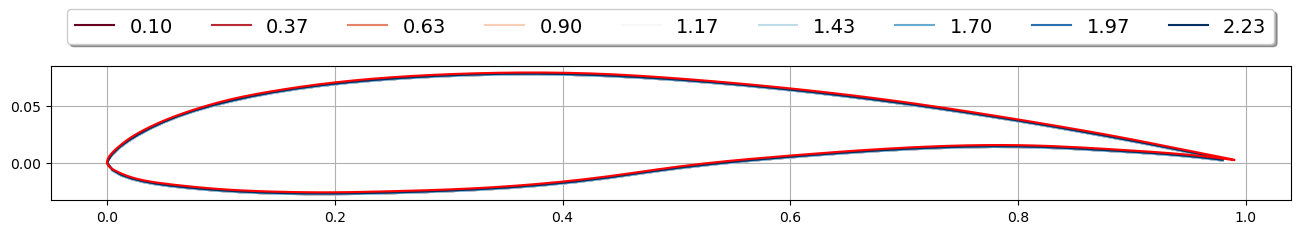

In [25]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot()

# Calculate the color for each dataset
cmap = plt.get_cmap('RdBu')
colors = [cmap(i) for i in np.linspace(0, 1, len(data_3d))]

for color, df in zip(colors, data_3d):
    x = df['CoordinateX']
    y = df['CoordinateY']
    zcoord = df['zcoord'].values[0]
    
    ax.plot(x,y, color=color, label=f'{zcoord:.2f}')

ax.plot(df_2d['CoordinateX'], df_2d['CoordinateY'], c='r')

ax.grid()
ax.set_aspect('equal')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5),
              ncol=len(data_3d), fancybox=True, shadow=True, fontsize=14)

# Set the azimuth and elevation angles
plt.savefig('coords.png')
plt.show()

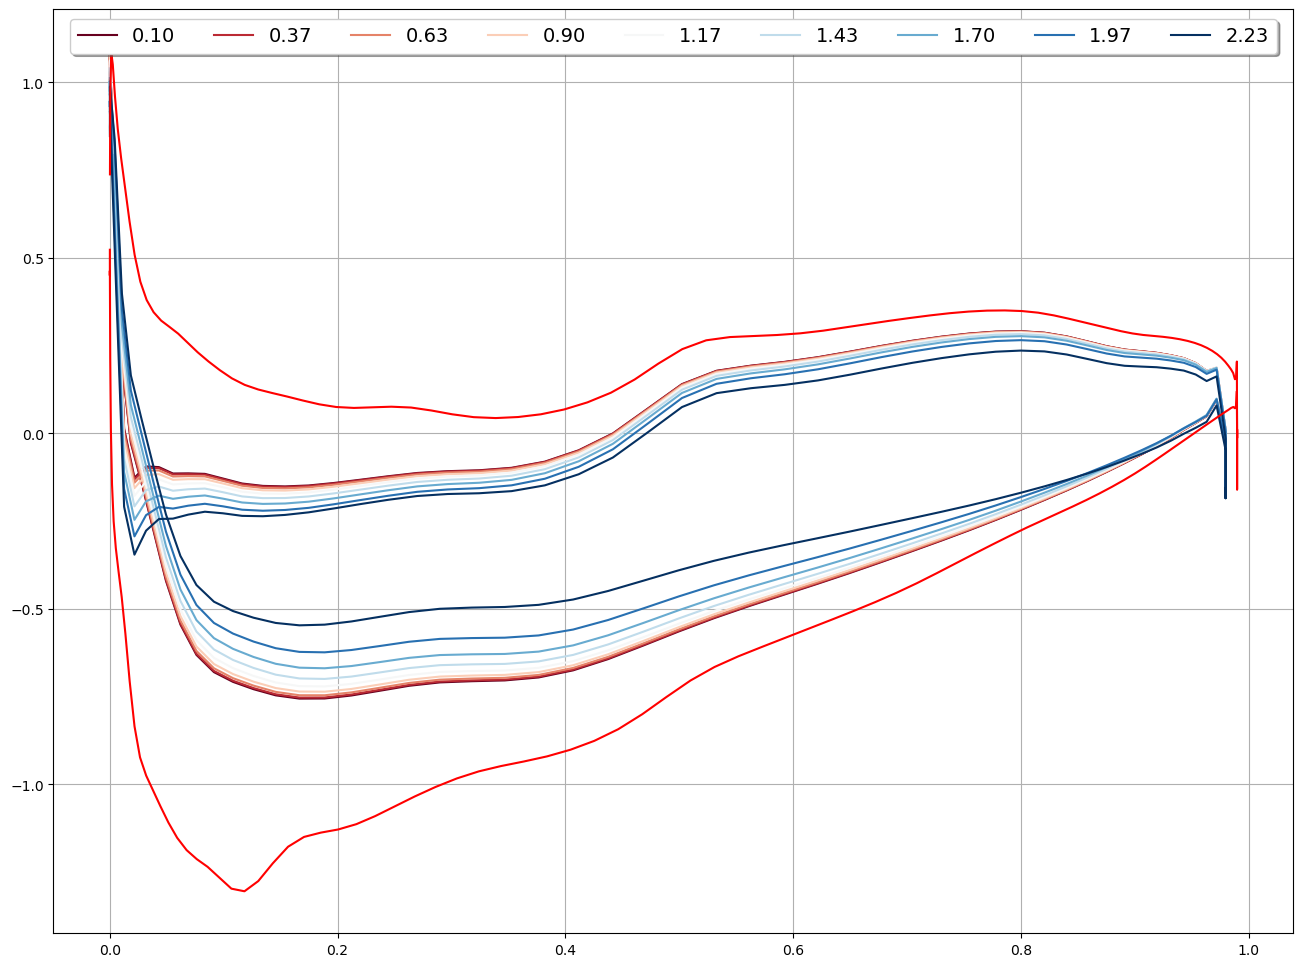

In [24]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot()

# Calculate the color for each dataset
cmap = plt.get_cmap('RdBu')
colors = [cmap(i) for i in np.linspace(0, 1, len(data_3d))]

for color, df in zip(colors, data_3d):
    x = df['CoordinateX']
    y = df['CoordinateY']
    zcoord = df['zcoord'].values[0]
    p = df['CP']
    
    ax.plot(x,p, color=color, label=f'{zcoord:.2f}')

ax.plot(df_2d['CoordinateX'], df_2d['CP'], c='r')

ax.grid()
#ax.set_aspect('equal')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.),
              ncol=len(data_3d), fancybox=True, shadow=True, fontsize=14)

# Set the azimuth and elevation angles
plt.savefig('pressure.png')
plt.show()

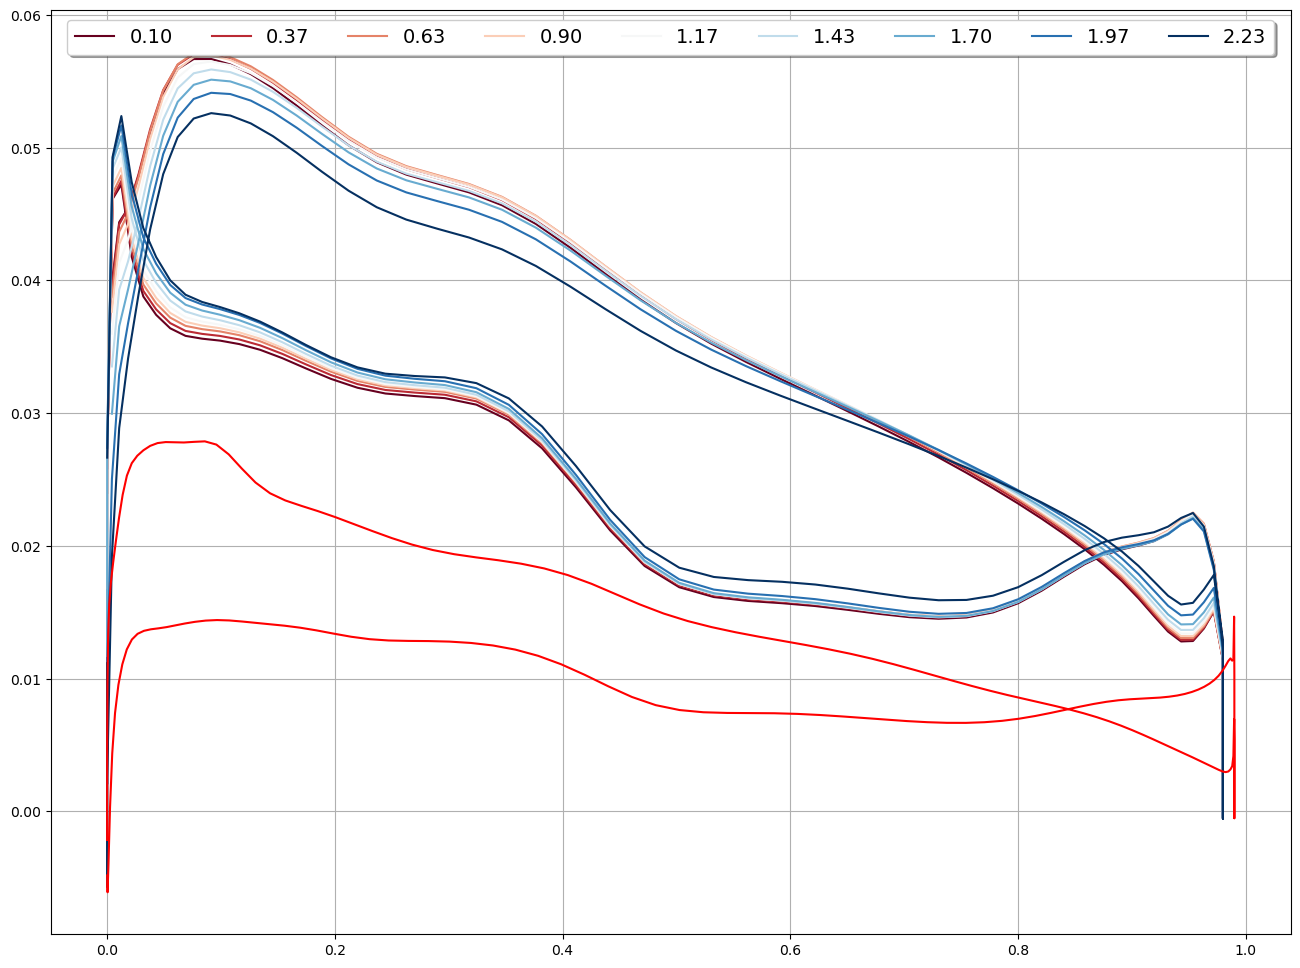

In [7]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot()

# Calculate the color for each dataset
cmap = plt.get_cmap('RdBu')
colors = [cmap(i) for i in np.linspace(0, 1, len(data_3d))]

for color, df in zip(colors, data_3d):
    x = df['CoordinateX']
    y = df['CoordinateY']
    zcoord = df['zcoord'].values[0]
    vx = df['VX']
    
    ax.plot(x,vx, color=color, label=f'{zcoord:.2f}')

ax.plot(df_2d['CoordinateX'], df_2d['VX'], c='r')

ax.grid()
#ax.set_aspect('equal')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.),
              ncol=len(data_3d), fancybox=True, shadow=True, fontsize=14)

# Set the azimuth and elevation angles
plt.savefig('coords.png')
plt.show()

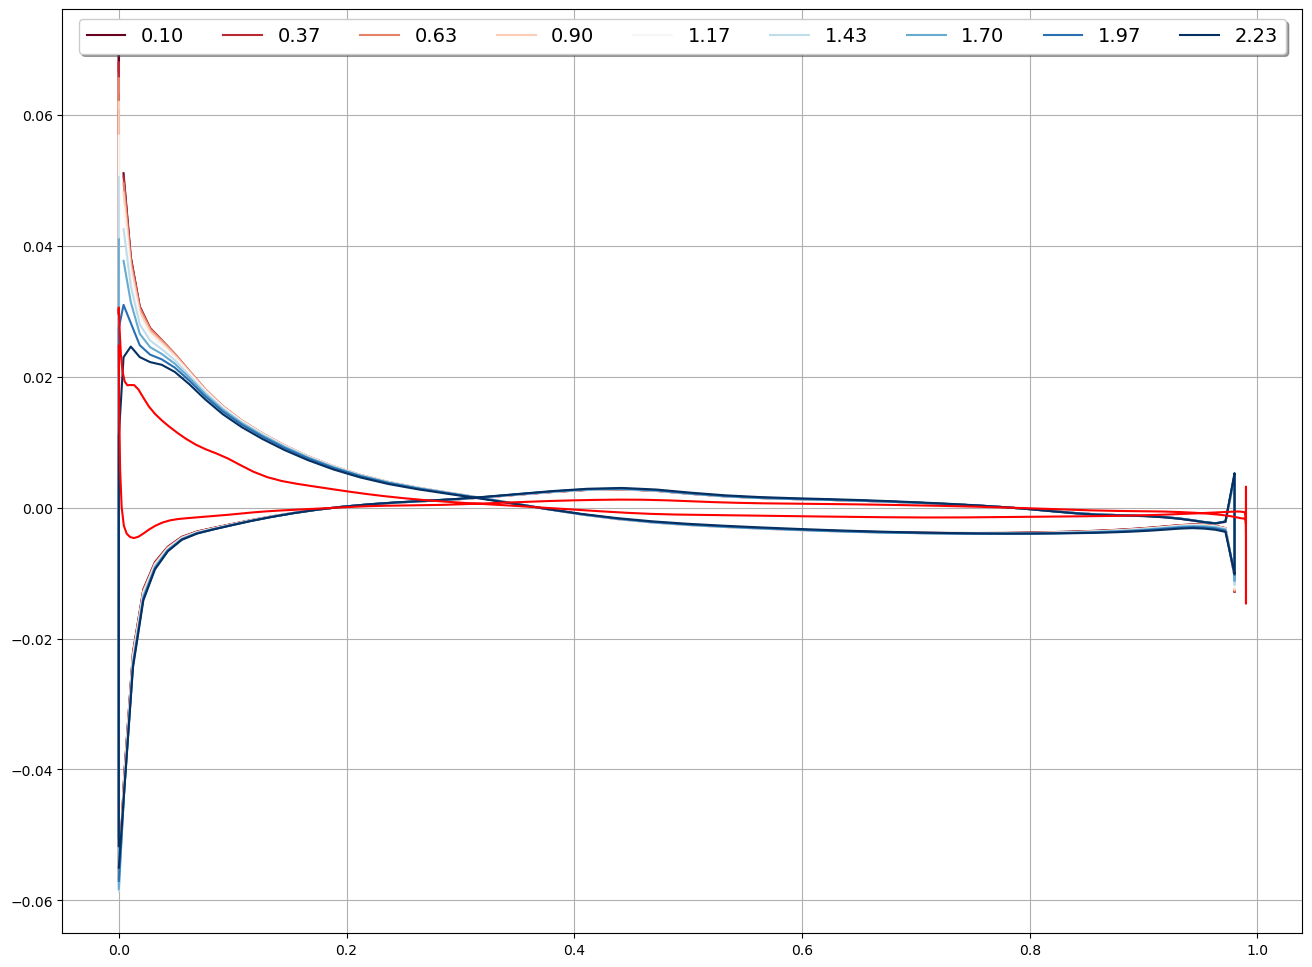

In [8]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot()

# Calculate the color for each dataset
cmap = plt.get_cmap('RdBu')
colors = [cmap(i) for i in np.linspace(0, 1, len(data_3d))]

for color, df in zip(colors, data_3d):
    x = df['CoordinateX']
    y = df['CoordinateY']
    zcoord = df['zcoord'].values[0]
    vy = df['VY']
    
    ax.plot(x,vy, color=color, label=f'{zcoord:.2f}')

ax.plot(df_2d['CoordinateX'], df_2d['VY'], c='r')

ax.grid()
#ax.set_aspect('equal')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.),
              ncol=len(data_3d), fancybox=True, shadow=True, fontsize=14)

# Set the azimuth and elevation angles
plt.savefig('coords.png')
plt.show()

# B-Spline Interpolation

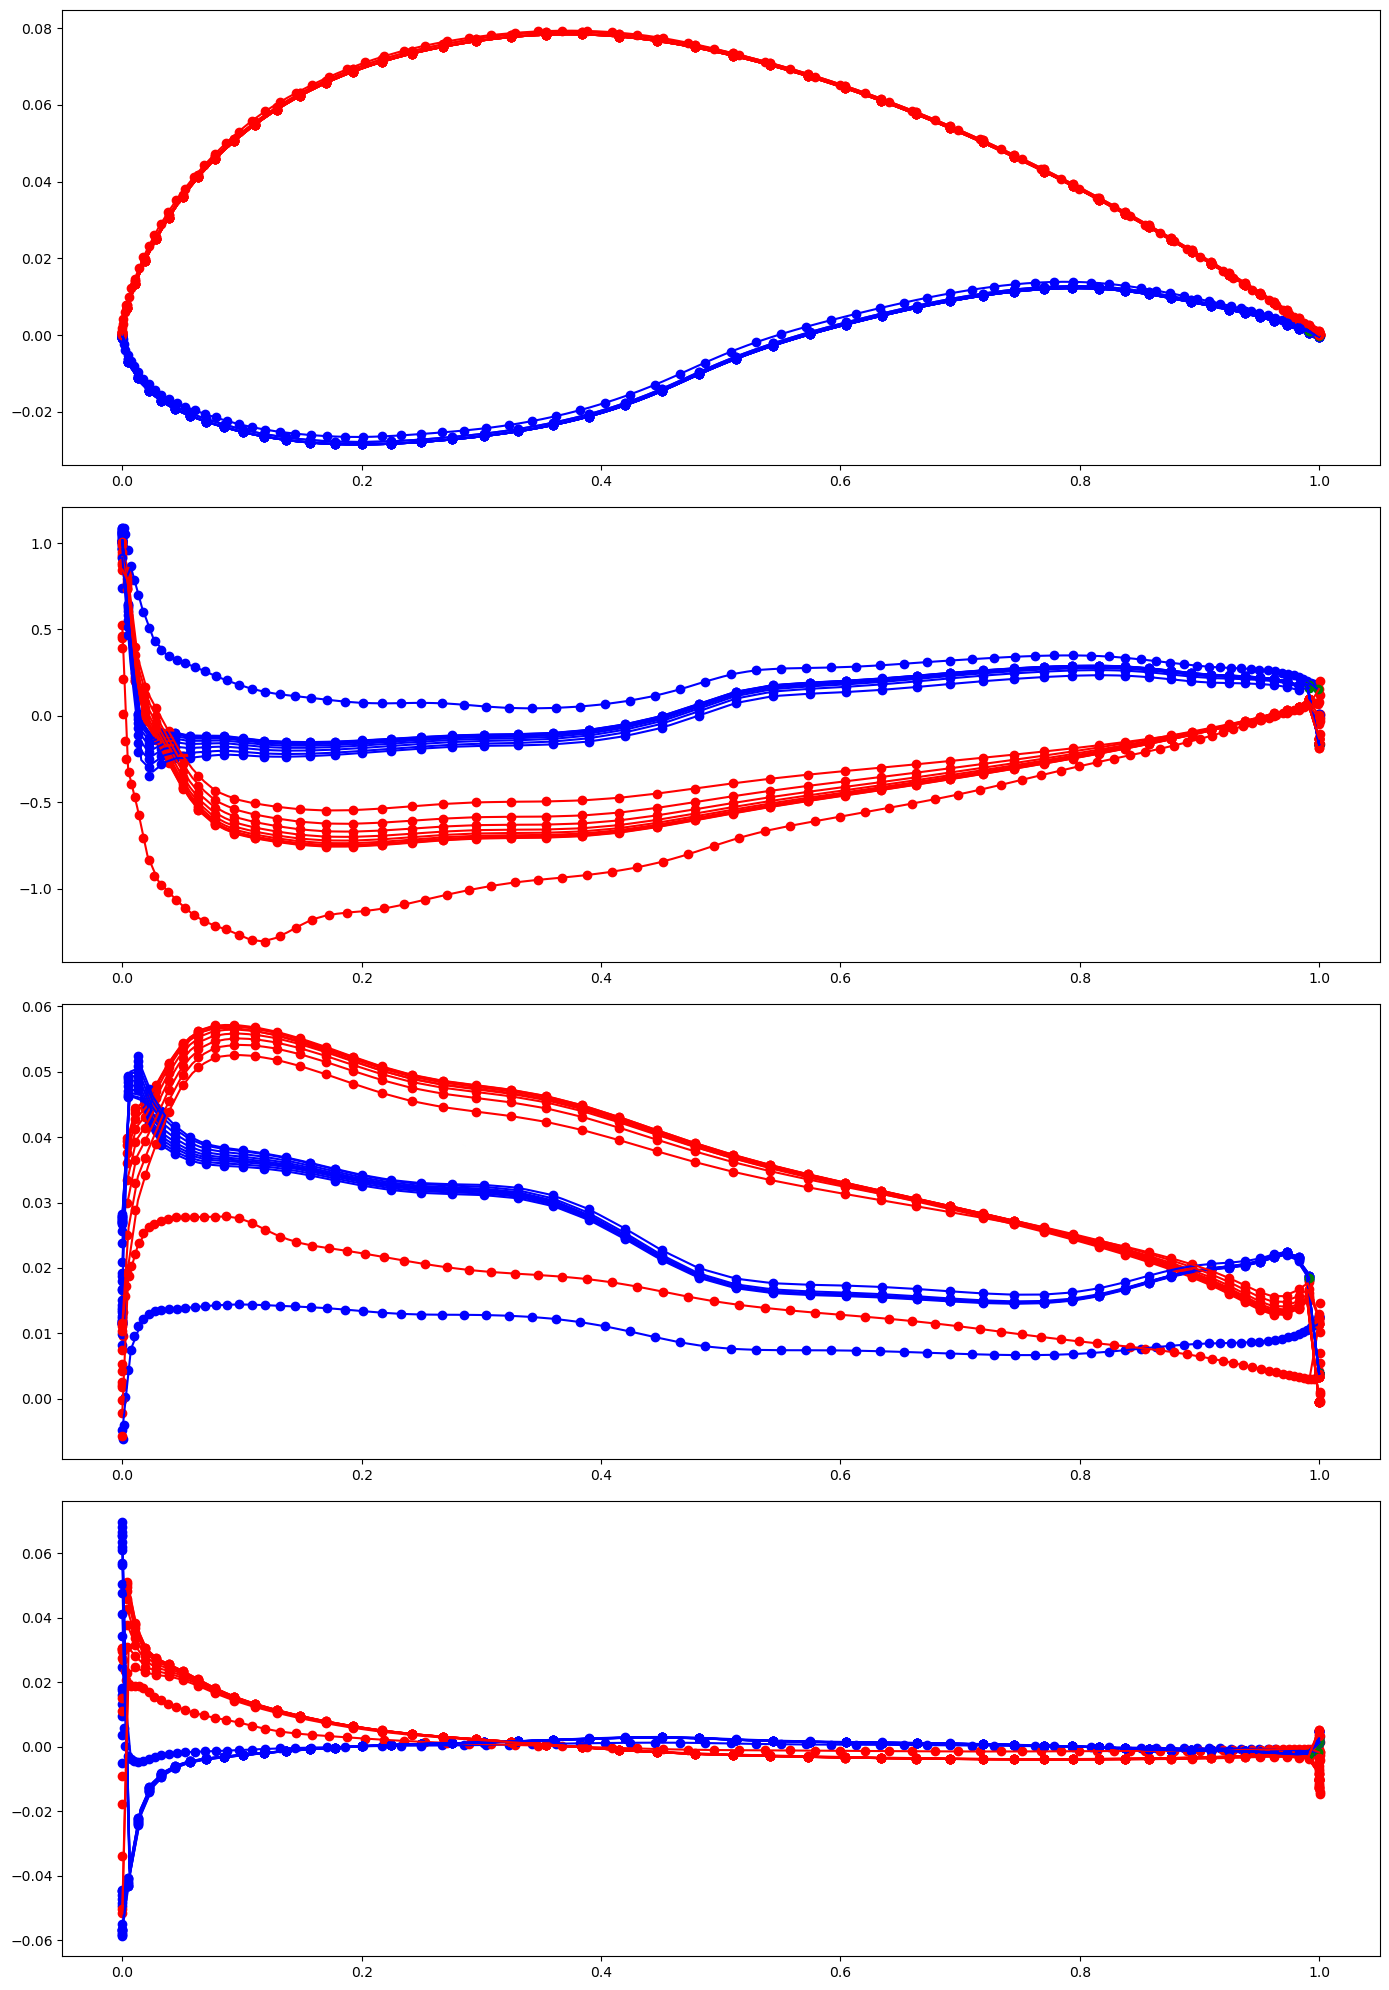

In [9]:
ns = 100
ndim = 2
nvar = 3
ndata = len(dataframes)
fig, axs = plt.subplots(nrows=1+nvar, ncols=1, figsize=(14,20), tight_layout=True)

geom_array = np.zeros((ndata, 2, ns, ndim))
field_array = np.zeros((ndata, 2, ns, nvar))

for i, df in enumerate(dataframes):
    # Fit raw spatial data to B-Splines
    x, y, cp, vx, vy = df['CoordinateX'].values, df['CoordinateY'].values, df['CP'].values, df['VX'].values, df['VY'].values

    vars = np.concatenate((cp.reshape(-1,1), vx.reshape(-1,1), vy.reshape(-1,1)), axis=1)
    
    xspline, yspline, s, xtip, ytip, idx_tip = fit_raw_Bspline(x, y)
    
    
    
    # Rotate and scale raw data
    x, y, xtip, ytip = rotate_scale(x, y, xtip, ytip)

    
    # Separate data (geometric and fluid) intp top and bottom components
    xyb, xyt, vb, vt, idx_tip = separate_top_bottom(x, y, vars, idx_tip)
    xb, yb, xt, yt = xyb[:,0], xyb[:,1], xyt[:,0], xyt[:,1]
        
    # Fit B-Spline to bottom processed coordinate/field data
    xysb, vsb, sb = spline_field_fit(xyb, vb, ns)
    
    # Fit B-Spline to top processed coordinate/field data
    xyst, vst, st = spline_field_fit(xyt, vt, ns)

    # Decompose x/y coordinates
    xsb, ysb, xst, yst = xysb[:,0], xysb[:,1], xyst[:,0], xyst[:,1]

    # Store geometry and field data
    geom_array[i,0,:,:], geom_array[i,1,:,:] =  xysb, xyst
    field_array[i,0,:,:], field_array[i,1,:,:] = vsb, vst
    
    # Geometry
    axs[0].scatter(xb, yb, c='b')
    axs[0].plot(xsb, ysb, c='b')
    axs[0].scatter(xt, yt, c='r')
    axs[0].plot(xst, yst, c='r')
    axs[0].scatter(xb[idx_tip], yb[idx_tip], c='g')
    
    # Field
    for i in range(nvar):
        axs[1+i].scatter(xb, vb[:,i], c='b')
        axs[1+i].plot(xsb, vsb[:,i], c='b')
        axs[1+i].scatter(xt, vt[:,i], c='r')
        axs[1+i].plot(xst, vst[:,i], c='r')
        axs[1+i].scatter(xb[idx_tip], vb[idx_tip,i], c='g')

In [10]:
geom_array.shape

(10, 2, 100, 2)

In [11]:
field_array.shape

(10, 2, 100, 3)

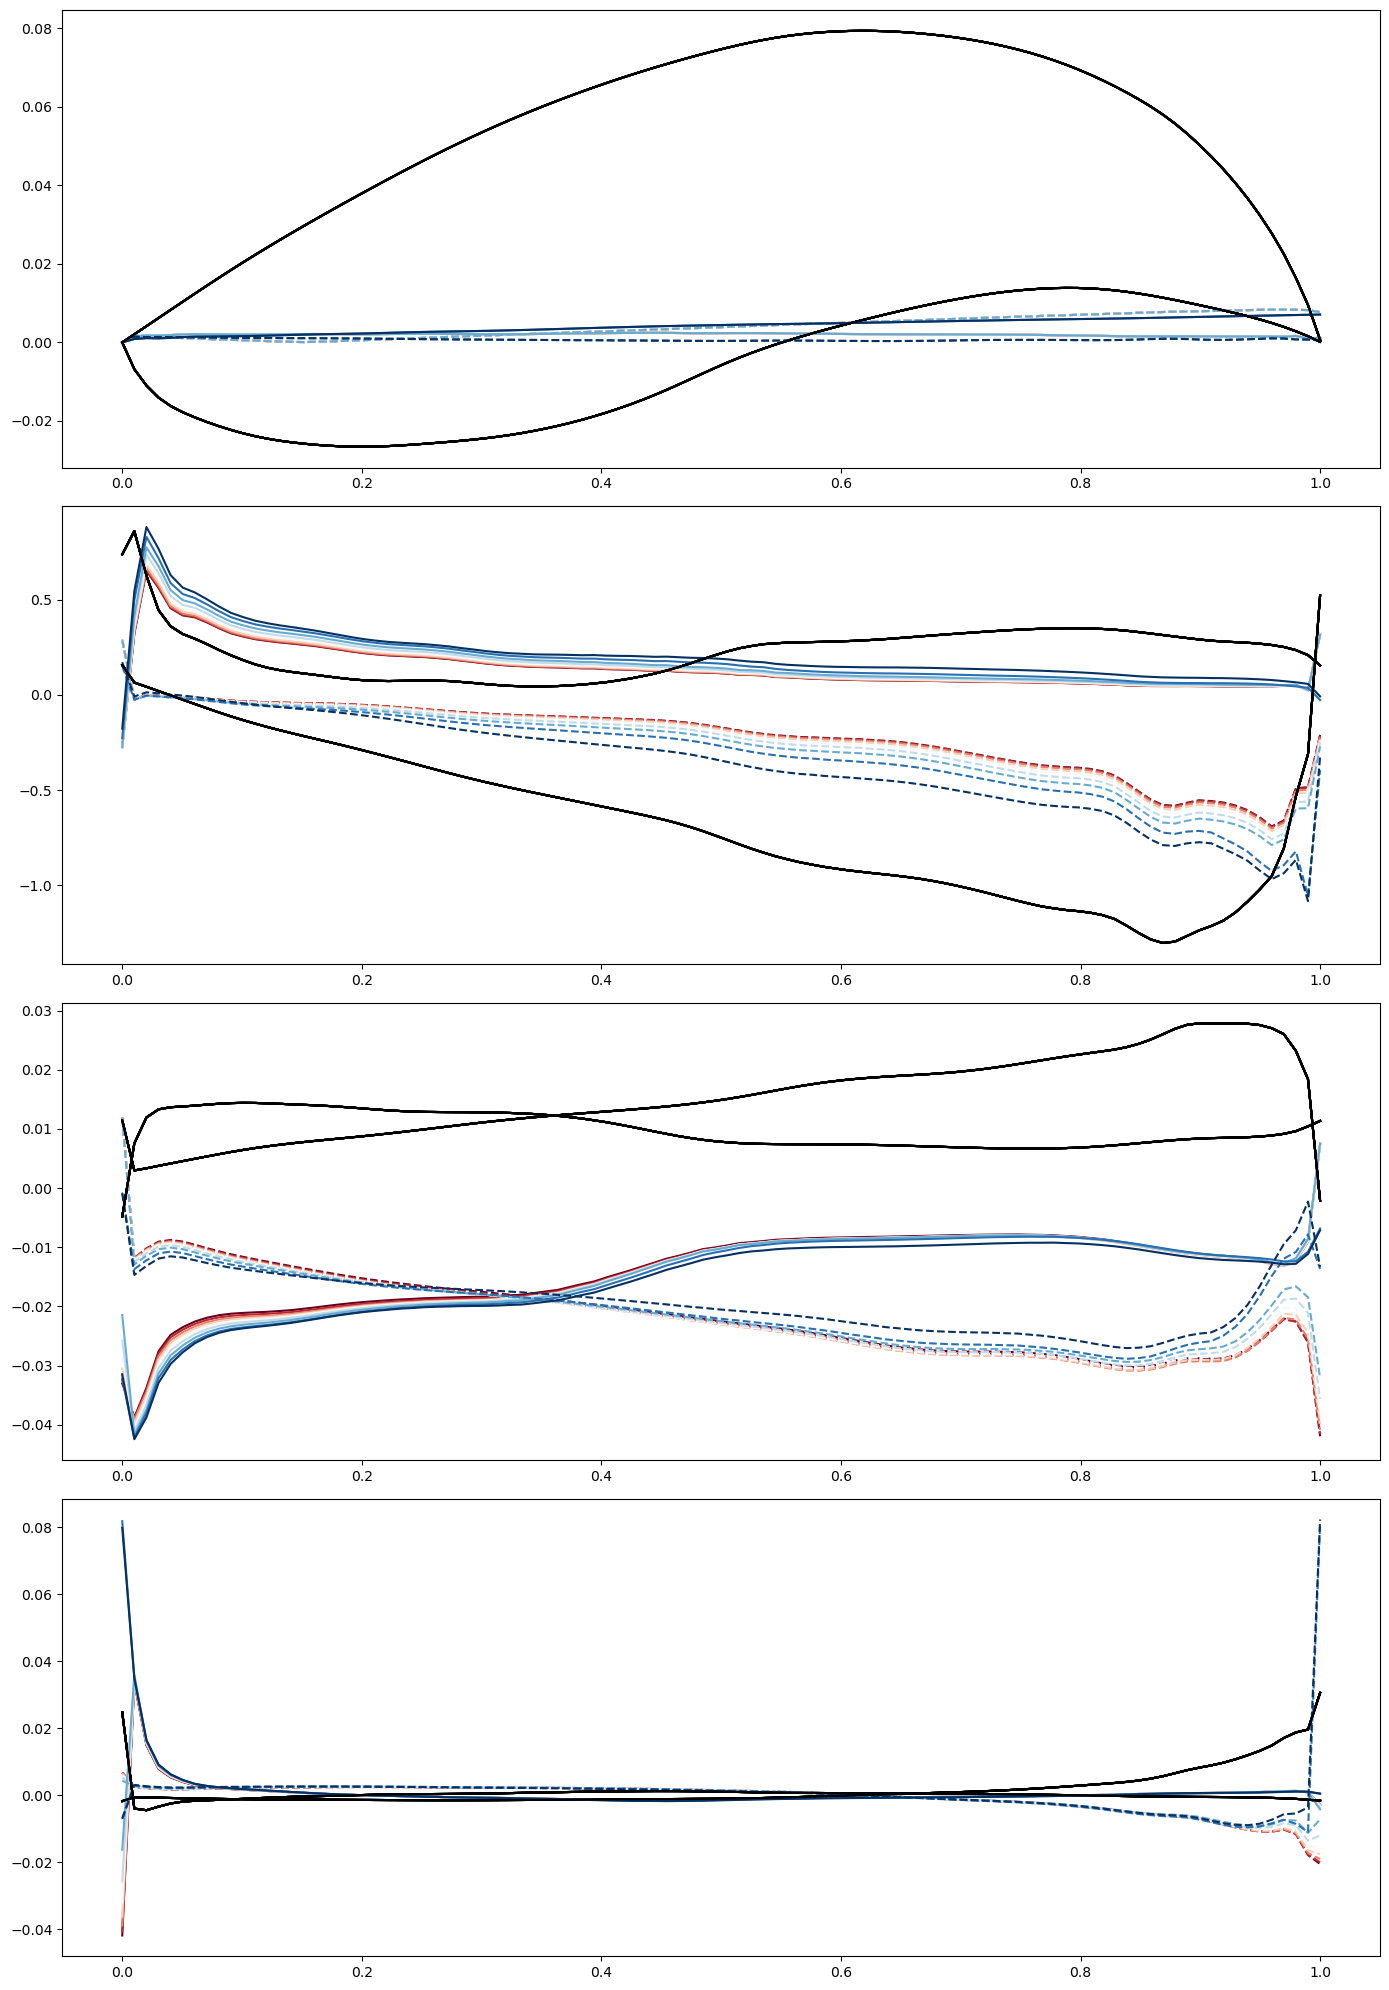

In [12]:
fig, axs = plt.subplots(nrows=1+nvar, ncols=1, figsize=(14,20), tight_layout=True)

# Calculate the color for each dataset
cmap = plt.get_cmap('RdBu')
colors = [cmap(i) for i in np.linspace(0, 1, geom_array.shape[0]-1)]

for i in range(1, geom_array.shape[0]):
    dx = np.sqrt(np.sum((geom_array[0, :, :, :] - geom_array[i, :, :, :])**2, axis=2))
    axs[0].plot(sb, dx[0,:], c=colors[i-1])
    axs[0].plot(st, dx[1,:], c=colors[i-1], linestyle='--')
    axs[0].plot(sb, geom_array[0, 0, :, 1], c='k')
    axs[0].plot(st, geom_array[0, 1, :, 1], c='k')

    for j in range(nvar):
        dv = field_array[0, :, :, j] - field_array[i, :, :, j]
        axs[j+1].plot(sb, dv[0,:], c=colors[i-1])
        axs[j+1].plot(st, dv[1,:], c=colors[i-1], linestyle='--')

        axs[j+1].plot(sb, field_array[0, 0, :, j], c='k')
        axs[j+1].plot(st, field_array[0, 1, :, j], c='k')

In [20]:
n3d = (geom_array.shape[0] - 1)
n2d = 1
Xb, Xt = [], []#np.zeros((n3d*ns, 4)), np.zeros((n3d*ns, 4))
Yb, Yt = [], []#np.zeros((n3d*ns, 3)), np.zeros((n3d*ns, 3))
zmax = 2.5

for i in range(n3d):
    df = dataframes[i+1]
    dx = np.sqrt(np.sum((geom_array[0, :, :, :] - geom_array[i+1, :, :, :])**2, axis=2))
    zcoord = dataframes[i+1]['zcoord'].values[0]

    #Xb[i*ns:(i+1)*ns, :] = np.concatenate((sb.reshape(-1,1), np.ones((ns,1))*zcoord, geom_array[i+1, 0, :, :]), axis=1)
    #Xt[i*ns:(i+1)*ns, :] = np.concatenate((st.reshape(-1,1), np.ones((ns,1))*zcoord, geom_array[i+1, 1, :, :]), axis=1)
    Xb.append(np.concatenate((sb.reshape(-1,1), np.ones((ns,1))*zcoord/zmax, geom_array[i+1, 0, :, :]), axis=1))
    Xt.append(np.concatenate((st.reshape(-1,1), np.ones((ns,1))*zcoord/zmax, geom_array[i+1, 1, :, :]), axis=1))

    dvb = np.zeros((ns,nvar))
    dvt = np.zeros((ns,nvar))
    for j in range(nvar):
        dvb[:,j] = field_array[0, 0, :, j] - field_array[i+1, 0, :, j]
        dvt[:,j] = field_array[0, 1, :, j] - field_array[i+1, 1, :, j]

        #Yb[i*ns:(i+1)*ns, j] = dv[0,:]
        #Yt[i*ns:(i+1)*ns, j] = dv[1,:]

    Yb.append(dvb)
    Yt.append(dvt)

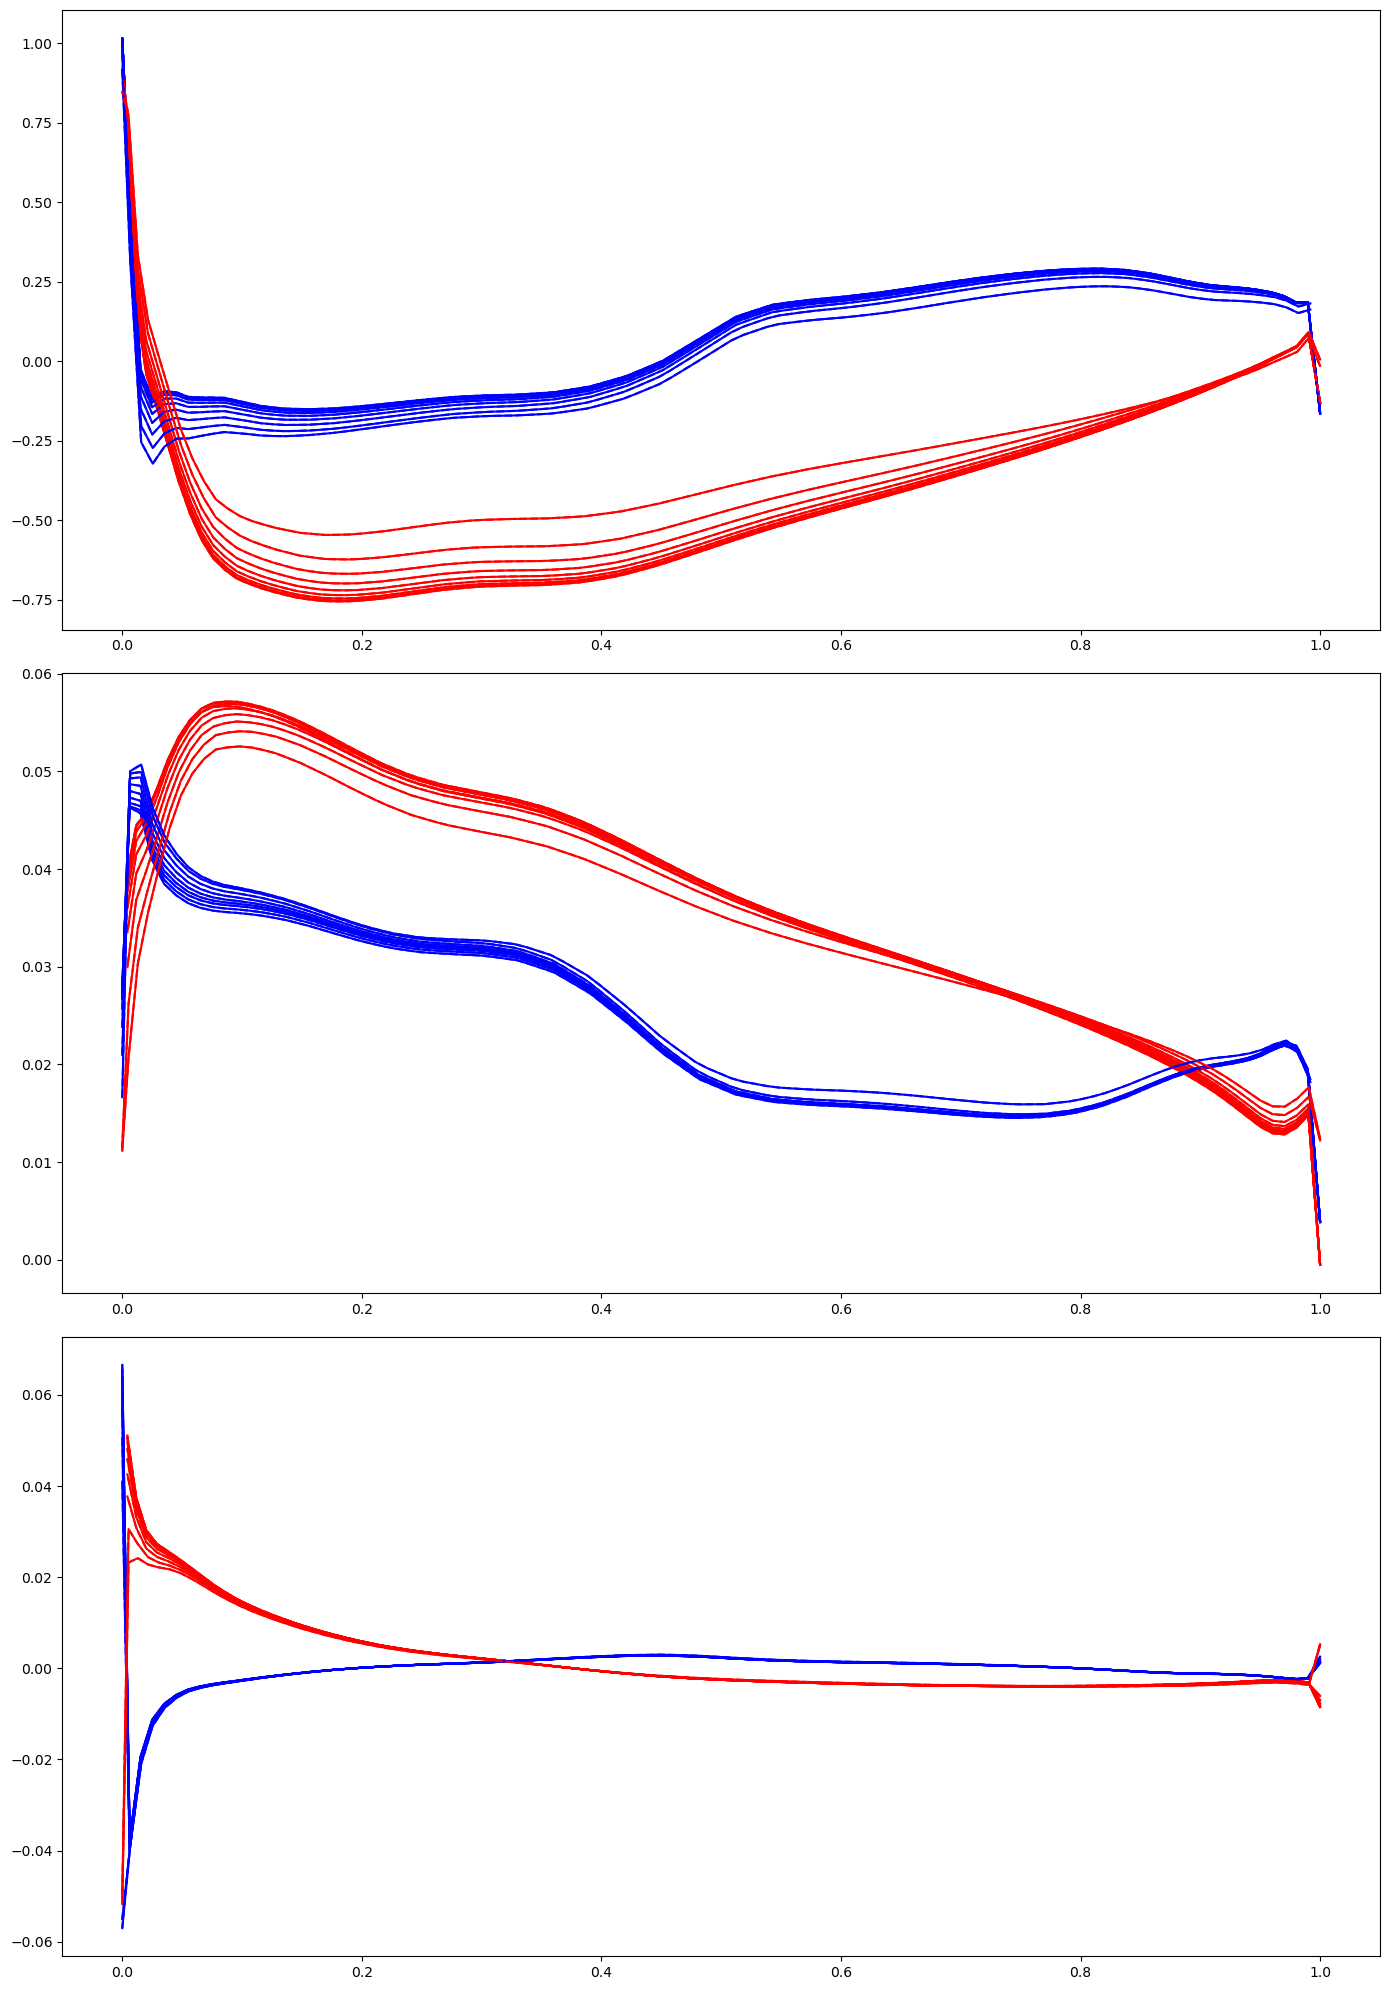

In [21]:
fig, axs = plt.subplots(nrows=nvar, ncols=1, figsize=(14,20), tight_layout=True)

# Calculate the color for each dataset
cmap = plt.get_cmap('RdBu')
colors = [cmap(i) for i in np.linspace(0, 1, geom_array.shape[0]-1)]

vref = field_array[0,:,:,:]
xref = geom_array[0,:,:,:]

for i in range(len(Xb)):
    sb, st = Xb[i][:,0], Xt[i][:,0]
    xb, xt = Xb[i][:,2], Xt[i][:,2]
    yb, yt = Xb[i][:,3], Xt[i][:,3]

    for j in range(nvar):
        dvb, dvt = Yb[i][:,j], Yt[i][:,j]
        vb_3d = vref[0,:,j]-dvb
        vt_3d = vref[1,:,j]-dvt
        
        axs[j].plot(xb, vb_3d, c='b')
        axs[j].plot(xt, vt_3d, c='r')
        #axs[j].plot(st, dv[1,:], c=colors[i-1], linestyle='--')

        axs[j].plot(xb, field_array[i+1, 0, :, j], c='b', linestyle='--')
        axs[j].plot(xt, field_array[i+1, 1, :, j], c='r', linestyle='--')

In [22]:
import pickle
data = (Xb, Xt, Yb, Yt)
with open("data.pickle","wb") as f:
    pickle.dump(data, f)

In [23]:
distance_geometry = np.ones((ndata, ndata))*1e6

for i1 in range(ndata-1):
    for i2 in range(i1+1,ndata):
        db = np.sum(np.sqrt(np.sum((geom_array[i1,0,:,:] - geom_array[i2,0,:,:])**2, axis=1)))
        dt = np.sum(np.sqrt(np.sum((geom_array[i1,1,:,:] - geom_array[i2,1,:,:])**2, axis=1)))
        distance_geometry[i1, i2] = db + dt


distance_field = np.ones((ndata, ndata, nvar))*1e6

for i1 in range(ndata-1):
    for i2 in range(i1+1,ndata):
        for ivar in range(nvar):
            db = np.sum(np.sqrt(np.sum((field_array[i1,0,:,ivar] - field_array[i2,0,:,ivar])**2)))
            dt = np.sum(np.sqrt(np.sum((field_array[i1,1,:,ivar] - field_array[i2,1,:,ivar])**2)))
            distance_field[i1, i2, ivar] = db + dt

In [17]:
field_array.shape

(10, 2, 100, 3)

In [18]:
ns

100